<a href="https://colab.research.google.com/github/Animesh-Guchhait/Q-learning-Reinforcement-/blob/main/AML_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import itertools
from tqdm import tqdm
import random
%matplotlib inline

Racetrack Environment building

In [ ]:
#This class is used to represent the race track as the Racetrack environment

class Racetrack:
  def __init__(self, track_file, reward=10):  #Initializing the Racetrack by reading the race track file
    with open(track_file,'r') as f:
      track = f.readlines()                                     
    self.arr = self.build_track(track)                       #Building the Racetrack
    self.m, self.n = self.arr.shape[0], self.arr.shape[1]
    self.reward = reward                                      #Initializing the reward for going out of track, collision or reaching goal
   


  def build_track(self, track):      #build track helps to build the racetrack as Racetrack environment
    
    # 0: Start State (S)
    # 1: Other State (O)
    # 2: Obstacles State(X)
    # 3: Finish State(F) 

    if track[-1]=='\n':
        track.pop()
      
    m = len(track)
      
    arr = []

    for i in range(m-1,-1,-1):
      t = []
      for j in range(len(track[i])):
        if track[i][j]!='\n':
          if track[i][j] =='S':
            t.append(0)
          elif track[i][j] =='O':
            t.append(1)
          elif track[i][j] == 'X':
            t.append(2)
          elif track[i][j] == 'F':
            t.append(3)
      arr.append(t)

    arr = np.array(arr)
    return arr
  
  def plot_track(self):                 # to plot the race track
    cmap = ListedColormap(['r','white','k','g'])
    
    t = np.zeros((self.m, self.n))
    for i in range(self.m-1, -1, -1):
      for j in range(self.n):
        t[(self.m-1) - i][j] = self.arr[i][j]

    plt.matshow(t, cmap = cmap)
    plt.axis('off')
    plt.show()

  def plot_episode(self,episode, end_state):      # to plot an episode of the agent(car)

    t1 = self.arr.copy()
    for ep in episode:
      s = ep[0]
      i,j = s
      t1[i,j] = 4

    if (end_state[0]>=(self.m-1)) and (0<=end_state[1]<self.n):
      t1[self.m-1,end_state[1]] = 4 
    elif (0<=end_state[0]<self.m) and (0<=end_state[1]<self.n):
      t1[end_state[0], end_state[1]] = 4
    
    cmap = ListedColormap(['r','white','k','g','pink'])
    
    t = np.zeros((self.m, self.n))
    for i in range(self.m-1, -1, -1):
      for j in range(self.n):
        t[(self.m-1) - i][j] = t1[i][j]

    plt.imshow(t, cmap = cmap)
    
    plt.axis('off')
    plt.show()

  
  def update_state(self, s, a):      #to get the new state of the agent based on it's past state and action chosen 
    s_new = (s[0] + a[0], s[1] + a[1])
    return (s_new)

 
  def isTerminal(self, s):             #to check if a given state is a terminal state
    i = s[0]
    j = s[1]
    if (i<0) or (j<0) or (j>=self.n) or(i>=self.m):     #went out of racetrack
      return True
    if (self.arr[i,j]==2) or (self.arr[i,j]==3):        #hitting an obstacle or reaching goal
      return True
    return False

  def get_reward(self,state, hit_obstacle=False):        #to get reward for current state
    if hit_obstacle ==True:
      return -(self.reward)
    i,j = state[0], state[1]
    if (i<0) or (j<0) or (j>=self.n):
      return -(self.reward)
    elif (i>=self.m):
      return self.reward
    elif self.arr[i,j]==3:
      return self.reward
    elif self.arr[i,j]==2:
      return -(self.reward)
    return -1

  def sample_start_state(self):          # to sample a start state for the agent
    j = np.random.randint(0,self.n)
    return (0,j)
    

**Q Learning Method**

In this assignment,We are useing the Q-Learning Algorithm.Here the agent(car) is represented by the TD_Agent class. 

In [ ]:
#Class to represent the agent(car)
class TD_Agent:
  def __init__(self, epsilon = 0.2):
    #Building the agent with parameters epsilon, the action space possible and initial velocity
    self.epsilon = epsilon
    self.actions = self.actions()
    self.velocity = (0,0)


  def initialize(self, states, env):
    #Initialize  q(s,a) arbitrarily for each state and action except the target state which has q(s,a) = 0
    self.q = {}
    for s in states:
      for a in self.actions:
        s_a = (s,a)
        if (not env.isTerminal(s)):
          self.q[s_a] = np.random.normal(-1,1)
        else:
          self.q[s_a] = 0                 
        
  def get_action(self,state, learn = True):  # to get the possible actions for a given state  
    if learn==True:
      t = -1
      prob_sample = np.random.uniform(0,1)
      if prob_sample <= self.epsilon:     #to explore
        while True:
          action = random.choice(self.actions)
          if self.action_valid(action):
            a = action
            break
      
      else:           #to exploit
        t = -999 
        best_actions = []
        for action in self.actions:
          x = (state, action)
          
          if (self.q[x]>t) and (self.action_valid(action)):
            best_actions = []
            t = self.q[x]
            best_actions.append(action)
          elif (self.q[x]==t) and (self.action_valid(action)):
            t = self.q[x]
            best_actions.append(action)

        if len(best_actions)>1:
          a = random.choice(best_actions)
        else:
          a = best_actions[0]
    
    else:       #sample action based on learnt agent
      t = -999 
      best_actions = []
      for action in self.actions:
        x = (state, action)
        
        if (self.q[x]>t) and (self.action_valid(action)):
          best_actions = []
          t = self.q[x]
          best_actions.append(action)
        elif (self.q[x]==t) and (self.action_valid(action)):
          best_actions.append(action)

      if len(best_actions)>1:
        a = random.choice(best_actions)
      else:
        a = best_actions[0]
    return a

 
  def action_valid(self, a):   #to check if action chosen is a valid action with respect to agent constraints
    vx = self.velocity[0] + a[0]
    vy = self.velocity[1] + a[1]

    if (vx==0 and vy==0):   #velocity cannot be zero except at start position
      return False

    if (np.abs(vx)<5) and (np.abs(vy)<5):       #absolute value of each velocity component must be less than 5
      return True
    
    return False

  def update_velocity(self, a):  # to update velocity of agent(car)
    vx = self.velocity[0] + a[0]
    vy = self.velocity[1] + a[1]
    self.velocity = (vx, vy)

  def reset_car(self):  # to reset car velocity after end of episode
    self.velocity = (0,0)


  def get_a_star(self, s):    # to chose greedily the action which gives max(q(s,a)) for a given state  
    t = -999
    best_actions = []
    for a in self.actions:
      state = (s,a)
      if self.q[state] > t:
        best_actions = []
        t = self.q[state]
        best_actions.append(a)
      elif self.q[state]==t:
        best_actions.append(a)
    
    if len(best_actions)>1:
      a_star = random.choice(best_actions)
    else:
      a_star = best_actions[0]

    return a_star

  def actions(self):   # to build possible actions of the agent based on the problem statement
    possible_actions = [-1, 0, 1]   # -1:decrease velocity by one, 0: keep velocity unchanged, 1: increase velocity by 1
    return (list(itertools.product(possible_actions, possible_actions)))  
    
  




to determine if a move of the agent from state s to state s_new causes a collision. 

In [ ]:
def move_hit_obstacle(env, s, s_new):
  x_a, y_a = s
  x_b, y_b = s_new

  if x_a > x_b:
    min_x, max_x = x_b, x_a
  else:
    min_x, max_x = x_a, x_b

  if y_a > y_b: 
    min_y, max_y = y_b, y_a
  else:
    min_y, max_y = y_a, y_b

  dx = (max_x - min_x) + 1
  dy = (max_y - min_y) + 1
  t = env.arr[min_x:(min_x + dx),min_y:(min_y+dy)]
  
  for elem in t.flatten():
    if elem==2:
      return True
  return False

Implementation of Q-learning algorithm

In [ ]:
last_ep = None
# implement the Q-Learning algorithm
def Q_L(agent, env, alpha = 0.5,discount_factor = 0.9, epsilon = 0.2, episodes = 50000, goals_desired = 10000):
  global last_ep
  
  #Initialize Q(S,A)
  states = list(itertools.product(range(env.m), range(env.n)))
  agent.initialize(states,env)

  episode_number = 0
  goals_crossed = 0
  

  for episode_number in tqdm(range(episodes)):

    start_state = env.sample_start_state()
    
    s = start_state
    a = agent.get_action(s)
    agent.update_velocity(a)
    r = env.get_reward(s)

    episode = [(s,a,r)]
    
    s_new = env.update_state(s, agent.velocity)
    hit_obstacle = move_hit_obstacle(env, s,s_new)

    while (not env.isTerminal(s_new)) and (not hit_obstacle):
      
      a_star = agent.get_a_star(s_new)
      agent.q[(s,a)] = agent.q[(s,a)] + alpha*(r + (discount_factor* agent.q[(s_new, a_star)]) - agent.q[(s,a)])


      r = env.get_reward(s_new)
      s = s_new
      a = agent.get_action(s)
      agent.update_velocity(a)

      s_new = env.update_state(s, agent.velocity)
      hit_obstacle = move_hit_obstacle(env,s,s_new)
      episode.append((s,a,r))
    
    #Final Terminal state reward
    
    agent.q[(s,a)] = agent.q[(s,a)] + alpha*(r + (discount_factor * env.get_reward(s_new,hit_obstacle)) - agent.q[(s,a)])     

    agent.reset_car()
    
    if hit_obstacle==False:
      if s_new[0]>=env.m:        #acceleration caused car to go out of track crossing the finish line meanwhile
        goals_crossed+=1
        last_ep = (episode,s_new)
      
      if (0<=s_new[0]<env.m) and (0<=s_new[1]<env.n):
        if env.arr[s_new[0], s_new[1]] == 3:
          goals_crossed +=1
          last_ep = (episode,s_new)

    
    if goals_crossed >=goals_desired:
      print ("Goals crossed surpassed goals desired to stop. Stopping Learning!")
      break
    
  return goals_crossed

Show_trace is used to show states, actions and rewards of each time step.

In [ ]:
def show_trace(episode, end_state, end_reward):
  trace = {'Time': [], 'State': [], 'Action': [], 'Reward':[]}
  for i, ep in enumerate(episode):
    s, a, r = ep
    trace['Time'].append(i+1)
    trace['State'].append(s)
    trace['Action'].append(a)
    trace['Reward'].append(r)

  trace['Time'].append(len(episode)+1)
  trace['State'].append(end_state)
  trace['Action'].append("X")
  trace['Reward'].append(end_reward)

  result = pd.DataFrame(trace)
  print (result)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Track 1**

Building the racetrack environment for track 1 and applying the Q learning algorithm for the agent on this racetrack environment.

 Here we took a steeper reward of 30 and penalty 30 for track 1 as a reward of 10 and penalty of 10 was causing the algorithm to take a lot more time to converge to 10K episodes where agent crossed goal state.

In [ ]:
env = Racetrack('/content/drive/MyDrive/track-1.txt', reward = 30)
td_agent = TD_Agent()
Q_L(td_agent, env, alpha = 0.6, epsilon = 0.2, discount_factor = 0.95, episodes = 5000000)

 61%|██████    | 3038558/5000000 [24:00<15:29, 2109.32it/s]

Goals crossed surpassed goals desired to stop. Stopping Learning!


10000

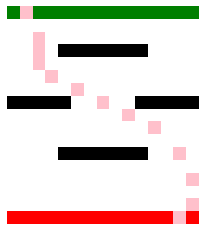

In [ ]:
episode, end_state = last_ep           # Plot of the path of the agent car
end_reward = env.get_reward(end_state)
env.plot_episode(episode, end_state)

In [ ]:
show_trace(episode, end_state, end_reward) # states actions and rewards for each step

    Time    State   Action  Reward
0      1  (0, 13)   (1, 1)      -1
1      2  (1, 14)  (1, -1)      -1
2      3  (3, 14)  (0, -1)      -1
3      4  (5, 13)  (0, -1)      -1
4      5  (7, 11)  (-1, 0)      -1
5      6   (8, 9)   (0, 0)      -1
6      7   (9, 7)   (0, 0)      -1
7      8  (10, 5)   (0, 0)      -1
8      9  (11, 3)   (0, 1)      -1
9     10  (12, 2)   (0, 1)      -1
10    11  (13, 2)   (0, 0)      -1
11    12  (14, 2)  (1, -1)      -1
12    13  (16, 1)        X      30


**Track 2**

Building the racetrack environment for track 2 and applying the Q learning algorithm for the agent on this racetrack environment.

Here we took a steeper reward of 50 and penalty 50 for track 2 as a reward of 30 and penalty of 30 was causing the algorithm to take a lot more time to converge to 10K episodes where agent crossed goal state.

In [ ]:
env = Racetrack('/content/drive/MyDrive/track-2.txt', reward = 50)
td_agent = TD_Agent()
Q_L(td_agent, env, alpha = 0.6, epsilon = 0.3, discount_factor = 0.95, episodes = 5000000)

100%|██████████| 5000000/5000000 [40:43<00:00, 2046.60it/s]


5055

Though we have increases the value of reward to 50, we could not achive targeted the 10k episodes goal. We have got 5055. So we need more iteration (more than 5000000).But let see how it's perfromence with this much learning.

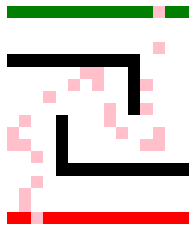

In [ ]:
episode, end_state = last_ep           # Plot of the path of the agent car
end_reward = env.get_reward(end_state)
env.plot_episode(episode, end_state)

Though learning have not achived the targeted episodes goal, the agent car reached it's destination smoothly for this racetrack.

In [ ]:
show_trace(episode, end_state, end_reward) # states actions and rewards for each step

    Time     State    Action  Reward
0      1    (0, 2)   (1, -1)      -1
1      2    (1, 1)    (0, 1)      -1
2      3    (2, 1)    (0, 1)      -1
3      4    (3, 2)   (1, -1)      -1
4      5    (5, 2)  (-1, -1)      -1
5      6    (6, 1)   (-1, 0)      -1
6      7    (6, 0)    (1, 1)      -1
7      8    (7, 0)    (0, 1)      -1
8      9    (8, 1)    (1, 1)      -1
9     10   (10, 3)   (-1, 0)      -1
10    11   (11, 5)   (0, -1)      -1
11    12   (12, 6)   (-1, 0)      -1
12    13   (12, 7)  (-1, -1)      -1
13    14   (11, 7)   (-1, 1)      -1
14    15    (9, 8)   (1, -1)      -1
15    16    (8, 8)    (0, 1)      -1
16    17    (7, 9)    (0, 1)      -1
17    18   (6, 11)   (1, -1)      -1
18    19   (6, 12)   (1, -1)      -1
19    20   (7, 12)   (1, -1)      -1
20    21   (9, 11)    (0, 1)      -1
21    22  (11, 11)    (1, 1)      -1
22    23  (14, 12)   (1, -1)      -1
23    24  (18, 12)         X      50


**Track 3**

Building the racetrack environment for track 3 and applying the Q learning algorithm for the agent on this racetrack environment.

Here we took a steeper reward of 40 and penalty 40 for track 3 

In [ ]:
env = Racetrack('/content/drive/MyDrive/track-3.txt', reward = 40)
td_agent = TD_Agent()
Q_L(td_agent, env, alpha = 0.6, epsilon = 0.3, discount_factor = 0.95, episodes = 5000000)

 18%|█▊        | 920491/5000000 [05:30<24:23, 2786.82it/s]

Goals crossed surpassed goals desired to stop. Stopping Learning!


10000

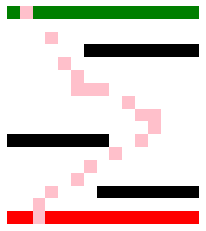

In [ ]:
episode, end_state = last_ep           # Plot of the path of the agent car
end_reward = env.get_reward(end_state)
env.plot_episode(episode, end_state)

In [ ]:
show_trace(episode, end_state, end_reward) # states actions and rewards for each step

    Time    State    Action  Reward
0      1   (0, 2)    (1, 0)      -1
1      2   (1, 2)    (0, 1)      -1
2      3   (2, 3)    (0, 1)      -1
3      4   (3, 5)   (0, -1)      -1
4      5   (4, 6)    (0, 1)      -1
5      6   (5, 8)    (0, 0)      -1
6      7  (6, 10)   (0, -1)      -1
7      8  (7, 11)   (0, -1)      -1
8      9  (8, 11)  (-1, -1)      -1
9     10  (8, 10)    (1, 0)      -1
10    11   (9, 9)   (0, -1)      -1
11    12  (10, 7)   (-1, 1)      -1
12    13  (10, 6)    (0, 0)      -1
13    14  (10, 5)    (1, 1)      -1
14    15  (11, 5)   (0, -1)      -1
15    16  (12, 4)    (1, 0)      -1
16    17  (14, 3)   (1, -1)      -1
17    18  (17, 1)         X      40


Building the racetrack environment for track 3 and applying the Q learning algorithm for the agent on this racetrack environment.

Here we took a steeper reward of 10 and penalty 10 for track 3

In [ ]:
env = Racetrack('/content/drive/MyDrive/track-3.txt', reward = 10)
td_agent = TD_Agent()
Q_L(td_agent, env, alpha = 0.6, epsilon = 0.3, discount_factor = 0.95, episodes = 5000000)

100%|██████████| 5000000/5000000 [04:17<00:00, 19393.16it/s]


8074

Here, we have used reward=10 and can not manage to get 10k episodes

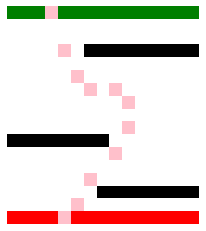

In [ ]:
episode, end_state = last_ep           # Plot of the path of the agent car
end_reward = env.get_reward(end_state)
env.plot_episode(episode, end_state)

In [ ]:
show_trace(episode, end_state, end_reward) # states actions and rewards for each step

    Time    State    Action  Reward
0      1   (0, 4)    (1, 1)      -1
1      2   (1, 5)    (1, 0)      -1
2      3   (3, 6)    (0, 1)      -1
3      4   (5, 8)   (0, -1)      -1
4      5   (7, 9)   (0, -1)      -1
5      6   (9, 9)  (-1, -1)      -1
6      7  (10, 8)  (-1, -1)      -1
7      8  (10, 6)    (1, 1)      -1
8      9  (11, 5)    (1, 0)      -1
9     10  (13, 4)    (1, 0)      -1
10    11  (16, 3)         X      10


From the above three task, we can get an idea that if task is more complex/hard, then we should use larger rewards for earlier convergence. 